<a href="https://colab.research.google.com/github/WngAndrew/Piano-Transcription/blob/master/piano_transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast

# For audio processing|
import torchaudio
from torchaudio.transforms import MelSpectrogram
import torchvision.transforms as T

import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from google.colab import drive

import random
import torch.backends.cudnn as cudnn

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
#view dir
parent_dir = '/content/drive/My Drive/processed_maestro_dataset_padded'

def list_files(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            print(os.path.join(root, file))

list_files(parent_dir)

/content/drive/My Drive/processed_maestro_dataset_padded/training_midi_0_chunk_0.npz
/content/drive/My Drive/processed_maestro_dataset_padded/training_mel_0_chunk_0.npz
/content/drive/My Drive/processed_maestro_dataset_padded/training_midi_1_chunk_0.npz
/content/drive/My Drive/processed_maestro_dataset_padded/training_mel_1_chunk_0.npz
/content/drive/My Drive/processed_maestro_dataset_padded/training_mel_2_chunk_0.npz
/content/drive/My Drive/processed_maestro_dataset_padded/training_midi_2_chunk_0.npz
/content/drive/My Drive/processed_maestro_dataset_padded/training_mel_3_chunk_0.npz
/content/drive/My Drive/processed_maestro_dataset_padded/training_midi_3_chunk_0.npz


In [ ]:
#define the custom dataset
class MaestroDataset(Dataset):
    def __init__(self, mel_dir, midi_dir, transform=None, pad_value=-999):
        self.pad_value = pad_value
        self.transform = transform

        # Load all .npz file paths
        self.mel_files = sorted([os.path.join(mel_dir, f) for f in os.listdir(mel_dir) if f.endswith('.npz')])
        self.midi_files = sorted([os.path.join(midi_dir, f) for f in os.listdir(midi_dir) if f.endswith('.npz')])

        assert len(self.mel_files) == len(self.midi_files), "Mismatch between mel and midi file counts"

        # For each file, load the .npz archive and store the keys
        self.mel_data = []
        self.midi_data = []
        for mel_file, midi_file in zip(self.mel_files, self.midi_files):
            mel_npz = np.load(mel_file, allow_pickle=True)
            midi_npz = np.load(midi_file, allow_pickle=True)
            mel_keys = list(mel_npz.keys())
            midi_keys = list(midi_npz.keys())
            assert mel_keys == midi_keys, f"Keys in {mel_file} and {midi_file} do not match"
            self.mel_data.extend([(mel_file, key) for key in mel_keys])
            self.midi_data.extend([(midi_file, key) for key in midi_keys])

    def __len__(self):
        return len(self.mel_data)

    def __getitem__(self, idx):
        mel_file, mel_key = self.mel_data[idx]
        midi_file, midi_key = self.midi_data[idx]

        mel_npz = np.load(mel_file, allow_pickle=True)
        midi_npz = np.load(midi_file, allow_pickle=True)

        mel = mel_npz[mel_key].astype(np.float32)
        midi = midi_npz[midi_key].astype(np.float32)

        if self.transform:
            mel = self.transform(mel)
            midi = self.transform(midi)

        mel_tensor = torch.from_numpy(mel).unsqueeze(0)
        midi_tensor = torch.from_numpy(midi)

        mel_mask = (mel_tensor != self.pad_value).float()
        midi_mask = (midi_tensor != self.pad_value).float()

        return mel_tensor, midi_tensor, mel_mask, midi_mask

"""
class MaestroDataset(Dataset):
  def __init__(self, mel_file_path, midi_file_path, transform=None, pad_value=-999):
        self.pad_value = pad_value
        self.mel_data = np.load(mel_file_path, allow_pickle=True)
        self.midi_data = np.load(midi_file_path, allow_pickle=True)
        self.transform = transform

        # Get a list of all the arrays (songs) in the .npz files
        self.mel_keys = list(self.mel_data.files)
        self.midi_keys = list(self.midi_data.files)

        assert len(self.mel_keys) == len(self.midi_keys), "Mismatch between mel and midi data sizes"
        self.length = len(self.mel_keys)

  def __len__(self):
        return len(self.mel_data)

  def __getitem__(self, idx):
        mel_key = self.mel_keys[idx]
        midi_key = self.midi_keys[idx]

        mel = self.mel_data[mel_key].astype(np.float32)
        midi = self.midi_data[midi_key].astype(np.float32)

        if self.transform:
            mel = self.transform(mel)
            midi = self.transform(midi)

        mel_tensor = torch.from_numpy(mel)
        midi_tensor = torch.from_numpy(midi)

        mel_tensor = mel_tensor.unsqueeze(0)

        mel_mask = (mel_tensor != self.pad_value).float()
        midi_mask = (midi_tensor != self.pad_value).float()

        return mel_tensor, midi_tensor, mel_mask, midi_mask
"""

'\nclass MaestroDataset(Dataset):\n  def __init__(self, mel_file_path, midi_file_path, transform=None, pad_value=-999):\n        self.pad_value = pad_value\n        self.mel_data = np.load(mel_file_path, allow_pickle=True)\n        self.midi_data = np.load(midi_file_path, allow_pickle=True)\n        self.transform = transform\n\n        # Get a list of all the arrays (songs) in the .npz files\n        self.mel_keys = list(self.mel_data.files)\n        self.midi_keys = list(self.midi_data.files)\n\n        assert len(self.mel_keys) == len(self.midi_keys), "Mismatch between mel and midi data sizes"\n        self.length = len(self.mel_keys)\n\n  def __len__(self):\n        return len(self.mel_data)\n\n  def __getitem__(self, idx):\n        mel_key = self.mel_keys[idx]\n        midi_key = self.midi_keys[idx]\n\n        mel = self.mel_data[mel_key].astype(np.float32)\n        midi = self.midi_data[midi_key].astype(np.float32)\n\n        if self.transform:\n            mel = self.transform(m

In [ ]:
mel_file_path = '/content/drive/MyDrive/processed_maestro_dataset_padded/'
midi_file_path = '/content/drive/MyDrive/processed_maestro_dataset_padded/'

dataset = MaestroDataset(mel_file_path, midi_file_path)

total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

training_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
validation_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
for mel_batch, midi_batch, mel_mask_batch, midi_mask_batch in training_dataloader:
    print(f"mel_batch shape: {mel_batch.shape}, midi_batch shape: {midi_batch.shape}")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 316, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 173, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 173, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 141, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 213, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [1, 128, 512] at entry 0 and [1, 128, 32768] at entry 1


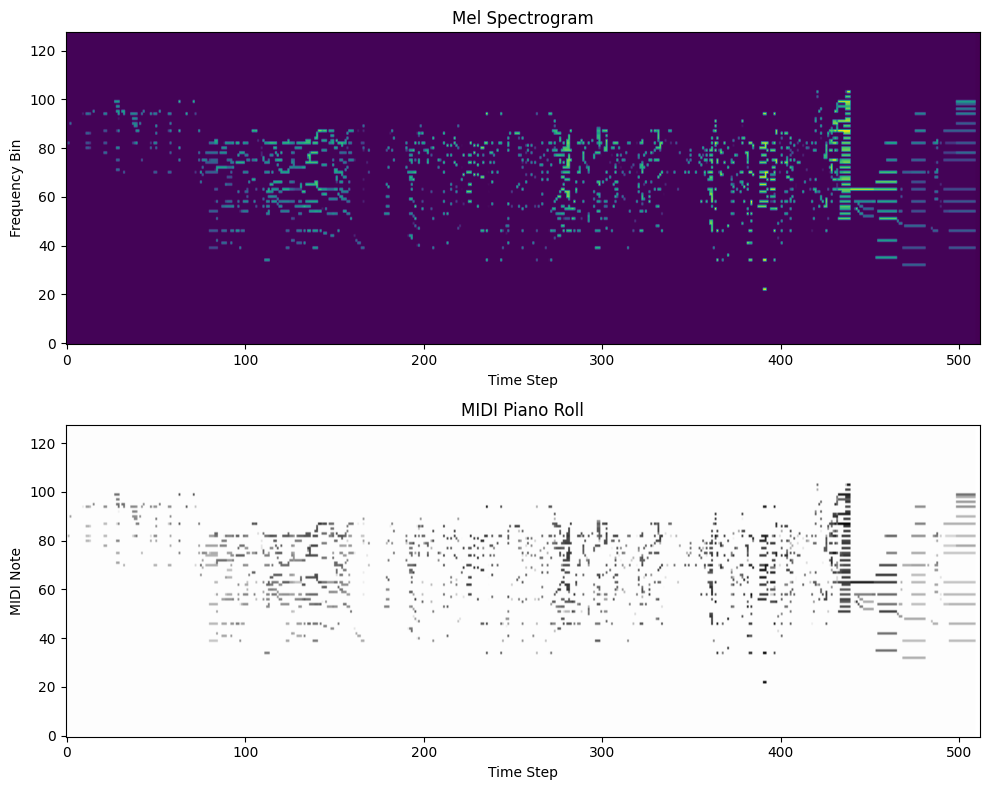

In [ ]:

def visualize_sample(mel, midi, mel_mask, midi_mask):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    mel = mel * mel_mask  # Apply mask to mel spectrogram
    midi = midi * midi_mask  # Apply mask to MIDI data

    # Mel spectrogram visualization
    mel = mel.squeeze()  # Remove channel dimension if it exists
    axes[0].imshow(mel, aspect='auto', origin='lower', cmap='viridis')
    axes[0].set_title("Mel Spectrogram")
    axes[0].set_xlabel("Time Step")
    axes[0].set_ylabel("Frequency Bin")

    # MIDI piano roll visualization
    axes[1].imshow(midi, aspect='auto', origin='lower', cmap='gray_r')
    axes[1].set_title("MIDI Piano Roll")
    axes[1].set_xlabel("Time Step")
    axes[1].set_ylabel("MIDI Note")

    plt.tight_layout()
    plt.show()

# Iterate through the dataloader and visualize the first batch
for mel, midi, mel_mask, midi_mask in training_dataloader:
    visualize_sample(mel[0].cpu().numpy(), midi[0].cpu().numpy(), mel_mask[0].cpu().numpy(), midi_mask[0].cpu().numpy())
    break

In [ ]:
class CRNN(nn.Module):
  def __init__(self):
    super(CRNN, self).__init__()
    # Input (1, 128, 32768)
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Output = (32, 128, 32768)
    self.pool1 = nn.MaxPool2d(kernel_size=(2, 4), stride=(2, 4))  # Output = (32, 64, 8192)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Output = (64, 64, 8192)
    self.pool2 = nn.MaxPool2d(kernel_size=(2, 4), stride=(2, 4))  # Output = (64, 32, 2048)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Output = (128, 32, 2048)
    self.pool3 = nn.MaxPool2d(kernel_size=(2, 4), stride=(2, 4))  # Output = (128, 16, 512)

    #recall that cnn output has been reformatted
    self.rnn = nn.LSTM(input_size=128*16, hidden_size=256, num_layers=2, batch_first=True)
    #outputs (batch_size, sequence length, hidden size) : (32, 512, 256)

    # Fully connected layer
    self.fc = nn.Linear(256, 128)

  def forward(self, x):
    x = self.pool1(torch.relu(self.conv1(x)))
    x = self.pool2(torch.relu(self.conv2(x)))
    x = self.pool3(torch.relu(self.conv3(x)))

    # Reshape for RNN
    batch_size, channels, height, width = x.size()
    x = x.view(batch_size, width, channels * height)

    # Pass through RNN
    x, _ = self.rnn(x)

    # Predict pitch and velocity
    output = self.fc(x)  # (batch_size, sequence_length, 128)
    return output





In [ ]:
model = CRNN().to(device)
criterion = nn.MSELoss(reduction='none')  # Combined loss for pitch and velocity
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()
num_epochs = 10


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for mel, midi, mel_mask, midi_mask in training_dataloader:
        mel, midi, mel_mask, midi_mask = mel.to(device), midi.to(device), mel_mask.to(device), midi_mask.to(device)
        optimizer.zero_grad()

        # Use autocast for mixed precision training
        with autocast():
            output = model(mel)

            # Flatten output and midi to calculate the loss
            output = output.view(-1, 128)
            midi = midi.view(-1, 128)
            loss = criterion(output, midi)

            # Apply masking
            midi_mask = midi_mask.view(-1, 128).float()  # Ensure the mask matches the flattened size
            loss = loss * midi_mask

            loss = loss.sum() / midi_mask.sum()

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for mel, midi, mel_mask, midi_mask in validation_dataloader:
            mel, midi, mel_mask, midi_mask = mel.to(device), midi.to(device), mel_mask.to(device), midi_mask.to(device)
            with autocast():
                output = model(mel)

                # Flatten output and midi to calculate the loss
                output = output.view(-1, 128)
                midi = midi.view(-1, 128)
                loss = criterion(output, midi)

                # Apply masking
                midi_mask = midi_mask.view(-1, 128).float()  # Ensure the mask matches the flattened size
                loss = loss * midi_mask

                loss = loss.sum() / midi_mask.sum()

                val_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {running_loss / len(training_dataloader)}, Validation Loss: {val_loss / len(validation_dataloader)}")

/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 316, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 173, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 173, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 141, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/collate.py", line 212, in collate_tensor_fn
    out = elem.new(storage).resize_(len(batch), *list(elem.size()))
RuntimeError: Trying to resize storage that is not resizable
